# 📚 Проект: Классификация писателей русской литературы

Этот проект посвящён анализу стиля текстов и определению автора произведения на основе **предобученных векторных представлений слов (embeddings)**.  
Мы применяем **эмбеддинги Navec/Natasha**, чтобы распознавать стиль пяти известных писателей русской литературы.

---


### Загрузка предобученных Embedding

Загружаем архив с произведениями классиков

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
!pip install navec

In [ ]:
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
EMBEDDING_DIM = 300
MAX_WORDS = 10000

### Подготовка датасета

**Шаг 1. Загрузка базы писателей Русской литературы**

In [ ]:
import keras
data_path = keras.utils.get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

21547079/21547079 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Шаг 2. Распаковка датасета**

In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "{data_path}" -d ./dataset

**Шаг 3. Формирование датасета**

In [ ]:
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Gorky",]

In [ ]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой


all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
            # Загрузка содержимого файла в строку
            text = f.read()

        all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

**Шаг 4. Токенизация**

Используем библиотеку `razdel` для корректной русской токенизации.
Каждый текст разбивается на список токенов для обучения модели

In [ ]:
!pip install razdel

In [ ]:
from razdel import tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_dim = 300    # размерность эмбеддингов (совпадает с Navec)
max_words = 10000      # количество слов для словаря

# Токенизация текстов Razdel
def razdel_tokenize(text):
    # превращаем текст в строку токенов, разделённых пробелами
    tokens = [t.text for t in tokenize(str(text))]
    return " ".join(tokens)

# Применяем токенизацию ко всем авторам
# Превратим словарь all_texts в список текстов
author_names = list(all_texts.keys())
texts = list(all_texts.values())

# Токенизируем каждый текст Razdel’ом
texts_tokenized = [razdel_tokenize(t) for t in texts]

# Создаём токенайзер Keras — он теперь работает по токенам Razdel
tokenizer = Tokenizer(
    num_words=max_words,
    filters='',
    lower=True,
    split=' ',
    char_level=False
)

# Обучаем токенайзер на токенизированных текстах
tokenizer.fit_on_texts(texts_tokenized)

# Проверим результат
print(f"Всего авторов: {len(author_names)}")
print(f"Пример токенизированного текста ({author_names[0]}):")
print(texts_tokenized[0][:300])
print(f"Размер словаря: {len(tokenizer.word_index)}")

Всего авторов: 5
Пример токенизированного текста (Dostoevsky):
Федор Михайлович Достоевский УНИЖЕННЫЕ И ОСКОРБЛЕННЫЕ Роман в четырех частях с эпилогом ЧАСТЬ ПЕРВАЯ ГЛАВА I Прошлого года , двадцать второго марта , вечером , со мной случилось престранное происшествие . Весь этот день я ходил по городу и искал себе квартиру . Старая была очень сыра , а я тогда уже
Размер словаря: 210501


### Шаг 5. Преобразование текста в последовательности

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from collections import Counter
import random

random.seed(42)
np.random.seed(42)

# Приведём вход к единой форме: dict author -> tokenized_string
if isinstance(texts_tokenized, dict):
    tok_by_author = texts_tokenized
elif isinstance(texts_tokenized, list):
    if len(texts_tokenized) != len(author_names):
        raise ValueError("Если texts_tokenized — list, он должен быть той же длины, что и author_names")
    tok_by_author = {a: t for a, t in zip(author_names, texts_tokenized)}
else:
    raise ValueError("texts_tokenized должен быть list или dict")

# Используем tokenizer.texts_to_sequences для списка значений
authors = list(tok_by_author.keys())
texts_list = [tok_by_author[a] for a in authors]   # список токенизированных строк
sequences_list = tokenizer.texts_to_sequences(texts_list)  # list of list[int]

# Маппинг author -> sequence (список индексов)
sequences_by_author = {author: seq for author, seq in zip(authors, sequences_list)}

# Проверка
for a in authors:
    print(a, "len:", len(sequences_by_author[a]))


Dostoevsky len: 1970254
Tolstoy len: 1592990
Turgenev len: 401279
Chekhov len: 319558
Gorky len: 743392


### Шаг 6. Балансировка датасета

Уравниваем количество примеров для каждого автора, чтобы модель обучалась равномерно

In [ ]:
def balance_sequences(sequences_by_author, strategy='undersample', target_windows=None, window_size=50, step=25):
    """
    Возвращает dict author -> list of windows (каждое окно — list[int]).
    strategy: 'undersample' (по минимальному числу окон) или 'upsample' (по максимальному)
    target_windows: если указано — принудительно взять это количество окон на автора
    """
    windows_by_author = {}
    for author, seq in sequences_by_author.items():
        # границы — берём только те индексы, где можно получить хотя бы одно окно
        if len(seq) < window_size:
            windows = []  # недостаточно данных
        else:
            windows = [seq[i:i+window_size] for i in range(0, len(seq) - window_size + 1, step)]
        windows_by_author[author] = windows

    counts = {a: len(windows_by_author[a]) for a in windows_by_author}
    print("Окон на автора (до балансировки):", counts)

    # если target_windows явно указано — используем его
    if target_windows is None:
        if strategy == 'undersample':
            target = min(counts.values()) if counts else 0
        elif strategy == 'upsample':
            target = max(counts.values()) if counts else 0
        else:
            raise ValueError("strategy must be 'undersample' or 'upsample'")
    else:
        target = int(target_windows)

    balanced = {}
    for author, windows in windows_by_author.items():
        n = len(windows)
        if n == 0:
            balanced[author] = []
        elif n == target:
            balanced[author] = windows
        elif n > target:
            # случайное уменьшение (детерминированное seed выше)
            balanced[author] = random.sample(windows, target)
        else:
            # n < target -> дополняем с повторением
            reps = target // n
            rem = target % n
            balanced[author] = windows * reps + random.sample(windows, rem) if n>0 else []
    counts_after = {a: len(balanced[a]) for a in balanced}
    print("Окон на автора (после балансировки):", counts_after)
    return balanced

# Пример: задаём параметры окна
WINDOW_SIZE = 100   # длина окна в токенах
STEP = 50           # шаг (overlap = 50%)
# выберем стратегию undersample (уменьшение до минимального кол-ва окон)
balanced_windows = balance_sequences(sequences_by_author, strategy='undersample', window_size=WINDOW_SIZE, step=STEP)

# -------------------------

Окон на автора (до балансировки): {'Dostoevsky': 39404, 'Tolstoy': 31858, 'Turgenev': 8024, 'Chekhov': 6390, 'Gorky': 14866}
Окон на автора (после балансировки): {'Dostoevsky': 6390, 'Tolstoy': 6390, 'Turgenev': 6390, 'Chekhov': 6390, 'Gorky': 6390}


### Шаг 7. Нарезка примеров методом скользящего окна

Разделяем длинные тексты на фрагменты фиксированной длины для обучения

In [ ]:
X = []
y = []
author_to_id = {a: i for i, a in enumerate(sorted(balanced_windows.keys()))}
for author, windows in balanced_windows.items():
    aid = author_to_id[author]
    for w in windows:
        if len(w) == WINDOW_SIZE:
            X.append(w)
            y.append(aid)

X = np.array(X, dtype=np.int32)
y = np.array(y, dtype=np.int32)
print("Готово: примеров X:", X.shape, "меток y:", y.shape)
print("Mapping authors -> id:", author_to_id)

Готово: примеров X: (31950, 100) меток y: (31950,)
Mapping authors -> id: {'Chekhov': 0, 'Dostoevsky': 1, 'Gorky': 2, 'Tolstoy': 3, 'Turgenev': 4}


### Шаг 8. Вспомогательные функции

In [ ]:
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

def decode_sequence(seq, unk_token='<?>'):
    """Преобразовать список индексов в строку слов (без паддинга)"""
    return ' '.join([reverse_word_index.get(int(i), unk_token) for i in seq])

def get_class_distribution(y_array):
    cnt = Counter(y_array)
    return {k: cnt[k] for k in sorted(cnt)}

# Примеры вызова:
print("Пример окна (первые 1):", X[0][:20])
print("Декодированное окно:", decode_sequence(X[0][:20]))
print("Распределение по классам:", get_class_distribution(y))

# Сохранение / случайное перемешивание перед обучением
perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

Пример окна (первые 1): [  88 2687  223    1    6 1203   22   96   40   41    1    3 3205 5602
    1    6   23    1  952    1]
Декодированное окно: ей беспрерывно казалось , что коля к ней « » , и бывали случаи , что она , слезами ,
Распределение по классам: {np.int32(0): 6390, np.int32(1): 6390, np.int32(2): 6390, np.int32(3): 6390, np.int32(4): 6390}


### Шаг 9. Загрузка весов и создание Embedding-матрицы

In [ ]:
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_WORDS:
        continue
    if word in navec:
        embedding_matrix[i] = navec[word]
    else:
        # если слова нет в Navec — оставляем нулевой вектор
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (10000, 300)


### Шаг 10. Архитектура сети

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 56.0 MB/s eta 0:00:00


In [ ]:
from gensim.models import KeyedVectors
from keras import models, layers
from gensim.models import KeyedVectors
import tensorflow as tf

num_classes = len(author_to_id)

model = models.Sequential([
    layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=X.shape[1],
        trainable=False  # ❄️ замораживаем слой
    ),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(5),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

**Разделение данных на train/val/test**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Стратифицированное разделение
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 25560, Val: 3195, Test: 3195


**ReduceLROnPlateau**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

**Callback для сохранения лучшей эпохи**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',   # файл, куда сохраняем модель
    monitor='val_accuracy',        # по какой метрике выбираем лучшую
    save_best_only=True,           # сохраняем только лучшую
    mode='max',                    # максимизируем accuracy
    verbose=1
)

**Обучение модели**

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5415 - loss: 1.1294
Epoch 1: val_accuracy improved from -inf to 0.70391, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 87s 374ms/step - accuracy: 0.5421 - loss: 1.1282 - val_accuracy: 0.7039 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8119 - loss: 0.5346
Epoch 2: val_accuracy improved from 0.70391 to 0.82880, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 334ms/step - accuracy: 0.8120 - loss: 0.5345 - val_accuracy: 0.8288 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8870 - loss: 0.3512
Epoch 3: val_accuracy did not improve from 0.82880
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 319ms/step - accuracy: 0.8870 - loss: 0.3512 - val_accuracy: 0.8003 - val_loss: 0.5548 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9200 - los

**Загрузка лучшей модели и оценка на тесте**

In [ ]:
from keras.models import load_model

best_model = load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Точность на тестовых данных: {test_acc * 100:.2f}%")


🎯 Точность на тестовых данных: 91.05%


**График динамики обучения**

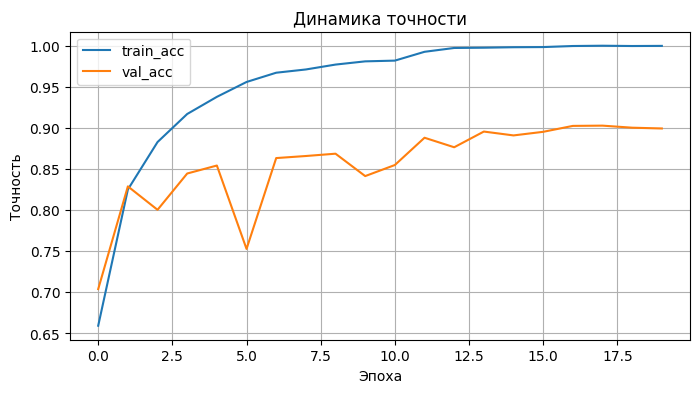

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Динамика точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
plt.show()
